In [4]:
import tensorflow as tf

import pathlib

import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow import layers
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)

1.13.0-dev20190111


In [5]:
data_path = keras.utils.get_file("auto-mpg.data", 
                                 "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
data_path

32768/30286================================] - 0s 7us/step


'/root/.keras/datasets/auto-mpg.data'

In [6]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(data_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [7]:
dataset.dropna()

origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

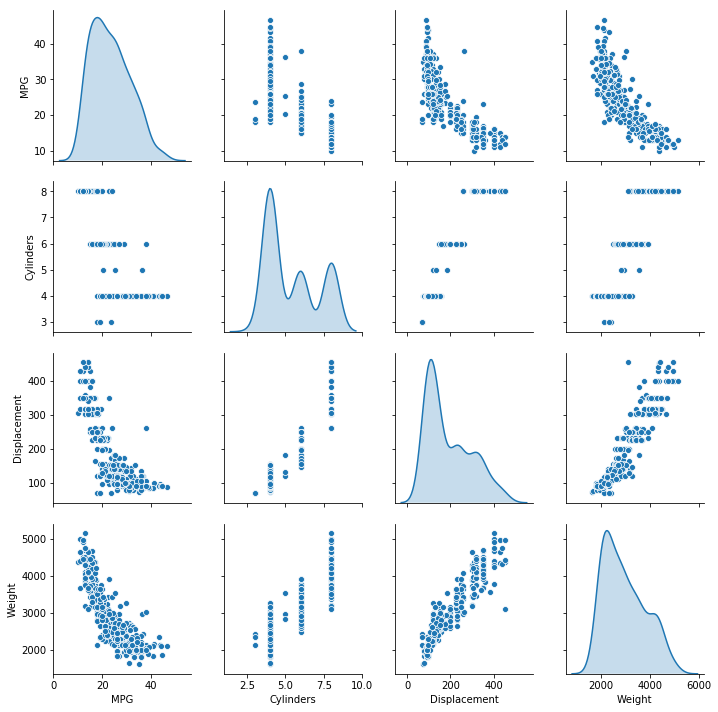

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,318.0,5.427673,1.682941,3.0,4.00,4.0,6.00,8.0
Displacement,318.0,193.061321,103.812742,70.0,100.25,151.0,259.50,455.0
Horsepower,313.0,104.067093,38.674662,46.0,75.00,92.0,120.00,230.0
Weight,318.0,2963.823899,844.749805,1613.0,2219.25,2792.5,3571.25,5140.0
Acceleration,318.0,15.595912,2.796282,8.0,13.90,15.5,17.30,24.8
Model Year,318.0,75.946541,3.705266,70.0,73.00,76.0,79.00,82.0
USA,318.0,0.641509,0.480313,0.0,0.00,1.0,1.00,1.0
Europe,318.0,0.163522,0.370424,0.0,0.00,0.0,0.00,1.0
Japan,318.0,0.194969,0.396801,0.0,0.00,0.0,0.00,1.0


It's time to seperate labels and feature.

In [11]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [12]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    return model

In [14]:
model = build_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [17]:
tensorBoard = TensorBoard()

history = model.fit(normed_train_data,
                   train_labels,
                   epochs=1000,
                   validation_split=0.2,
                   verbose=0,
                   callbacks=[tensorBoard])